In [1]:
import glob
import os
import io
import torch
import random
import cv2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import PIL.Image as pil
from torchvision import transforms
from PIL import Image, ImageChops, ImageEnhance
# from keras.utils.np_utils import to_categorical
import torch.nn.functional as F

/home/csgrad/akumar58/anaconda3/envs/manip/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
def convert_to_ela_image(path, quality):
        filename = path
        resaved_filename = '/home/csgrad/akumar58/EVAL4/cnn_manip/resave/' + 'resaved.jpg'
        print(resaved_filename)
        ELA_filename = filename.split('.')[0] + '.ela.png'
        
        im = Image.open(filename).convert('RGB')
        im.save(resaved_filename, 'JPEG', quality=quality)
        resaved_im = Image.open(resaved_filename)
        ela_im = ImageChops.difference(im, resaved_im)
        
        extrema = ela_im.getextrema()
        max_diff = max([ex[1] for ex in extrema])
        if max_diff == 0:
            max_diff = 1
        scale = 255.0 / max_diff
        
        ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
        return True

In [24]:
from datetime import datetime
import os

path = '/home/csgrad/akumar58/EVAL4/cnn_manip/train_files/' 
# print(datetime.today())
print(os.path.join(path,'{}/mode_weights.pth'.format(datetime.now().strftime("%Y%m%d-%H%M%S"))))

/home/csgrad/akumar58/EVAL4/cnn_manip/train_files/20230303-201554/mode_weights.pth


In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
train_file = open('./train_files/train_loss_20230307_23.pkl','rb')
test_file = open('./train_files/validation_loss_20230307_23.pkl','rb')

train_loss = pickle.load(train_file)
test_loss = pickle.load(test_file)

epoch_nums = np.arange(1,31)

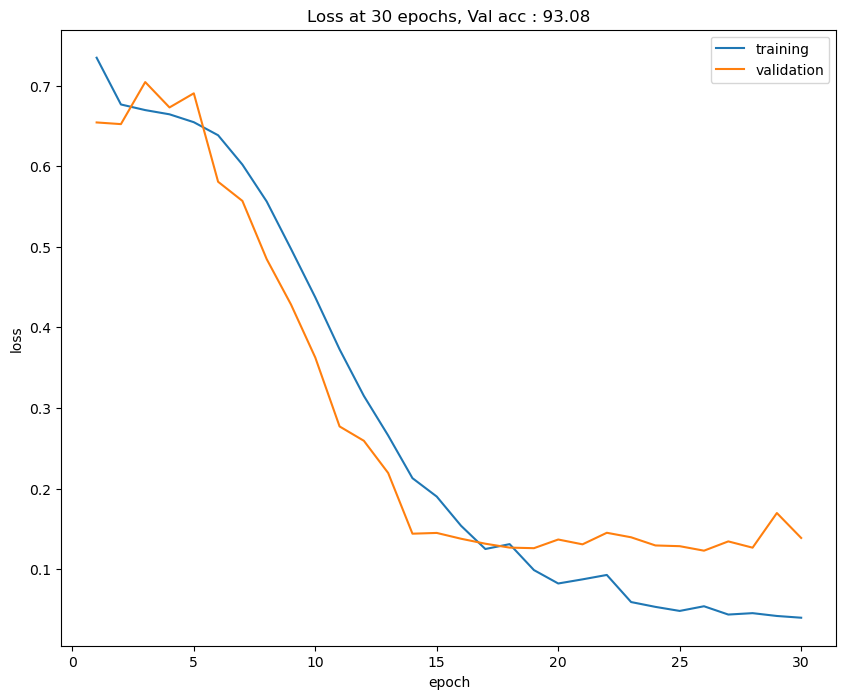

In [4]:
plt.figure(figsize=(10,8))
plt.plot(epoch_nums, train_loss)
plt.plot(epoch_nums, test_loss)
plt.title("Loss at 30 epochs, Val acc : 93.08")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [1]:
import torch

/home/csgrad/akumar58/anaconda3/envs/manip/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import os
import torch
import cv2
import glob
import random
import PIL.Image as pil
import numpy as np
import torch.nn as nn

/home/csgrad/akumar58/anaconda3/envs/manip/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
#resized 224x224 instead of 128x128

def cv2_enhance_contrast(img, factor):
            mean = np.uint8(cv2.mean(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))[0])
            img_deg = np.ones_like(img) * mean
            return cv2.addWeighted(img, factor, img_deg, 1-factor, 0.0)

def ela(path):
    quality = 90
    scale = 15
    orig = cv2.imread(path)
    orig = cv2.resize(orig, (128, 128), interpolation = cv2.INTER_AREA)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

    _, buffer = cv2.imencode(".jpg", orig, [cv2.IMWRITE_JPEG_QUALITY, quality])
    compressed_img = cv2.imdecode(np.frombuffer(buffer, np.uint8), cv2.IMREAD_COLOR)

    diff = scale * (cv2.absdiff(orig, compressed_img))
    ediff = cv2_enhance_contrast(diff, 0.25)
    ediff = ediff.astype(float)/255.0
    orig = orig.astype(float)/255.0
    return ediff, orig

In [34]:
path = '/home/csgrad/akumar58/EVAL4/test_images/1.jpg'
ela_im, org_im = ela(path)
temp = ela_im+org_im

libpng warning: iCCP: known incorrect sRGB profile


In [35]:
ela_im = pil.fromarray((ela_im * 255).astype(np.uint8))
org_im = pil.fromarray((org_im * 255).astype(np.uint8))

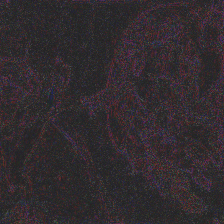

In [36]:
ela_im.show()

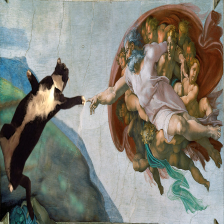

In [37]:
org_im.show()

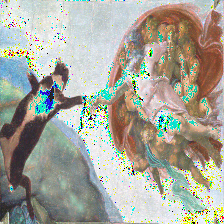

In [38]:
temp = pil.fromarray((temp * 255).astype(np.uint8))
temp.show()

In [59]:
model_path = '/home/csgrad/akumar58/EVAL4/cnn_manip/train_files/mode_weights_20230307_23.pth'
model = torch.load(model_path).to('cpu')
print(model)

Manip(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=115200, out_features=256, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)


In [60]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [68]:
model.conv1.register_forward_hook(get_activation('conv1'))

In [69]:
path = '/home/csgrad/akumar58/EVAL4/test_images/1.jpg'
ela_im, org_im = ela(path)
ela_image = torch.from_numpy(ela_im)
ela_image = ela_image.unsqueeze(0)
ela_image = ela_image.permute(0,3,1,2).to("cpu")

libpng warning: iCCP: known incorrect sRGB profile


In [70]:
output = model(ela_image).detach().to("cpu")

<built-in method size of Tensor object at 0x7f0892205130>


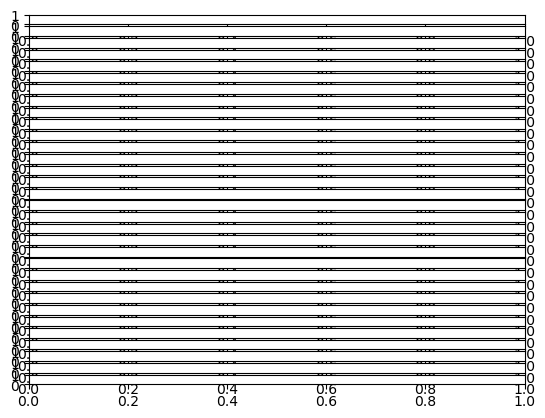

In [78]:
act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(act.size(0), 4)
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx],)


In [66]:
print(model)

Manip(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=115200, out_features=256, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)


In [21]:

import torch
import torchvision
import torch.nn as nn
import torch.utils.data as data
import numpy as np
from PIL import Image
from torch.autograd import Variable
from torchvision import models, transforms

use_gpu = torch.cuda.is_available()

In [42]:
class FeatureExtractor(nn.Module):
    def __init__(self, submodule, extracted_layers):
        super(FeatureExtractor, self).__init__()
        self.submodule = submodule
        self.extracted_layers = extracted_layers

    def forward(self, x):
        outputs = []
        for name, module in self.submodule._modules.items():
            if name is  "fc": 
                x = x.view(x.size(0), -1)
            x = module(x)
            if name in self.extracted_layers:
                outputs.append(x)
        return outputs

<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_3703553/2408135956.py:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if name is  "fc": x = x.view(x.size(0), -1)


In [35]:
extract_list = ["conv1", "maxpool", "layer1", "avgpool", "fc"]
img_path = "./1_00001.jpg"
saved_path = "./1_00001.txt"
resnet = models.resnet50(pretrained=True)

/home/csgrad/akumar58/anaconda3/envs/manip/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/csgrad/akumar58/anaconda3/envs/manip/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()]
)

In [37]:
img_path = '/home/csgrad/akumar58/EVAL4/test_images/1.jpg'
img = Image.open(img_path)
img = transform(img)

In [38]:
x = Variable(torch.unsqueeze(img, dim=0).float(), requires_grad=False)

In [55]:
if use_gpu:
    x = x.cuda()
    resnet = resnet.cuda()
extract_result = FeatureExtractor(resnet, extract_list)
res = (extract_result(x)[3])
print(res.shape)

torch.Size([1, 2048, 1, 1])


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import cv2 as cv
import argparse
from torchvision import models, transforms

# ap = argparse.ArgumentParser()
# ap.add_argument('-i', '--image', required=True,
#     help='path to image')
# args = vars(ap.parse_args())

# load the model
model = models.resnet18(pretrained=True)
print(model)
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")



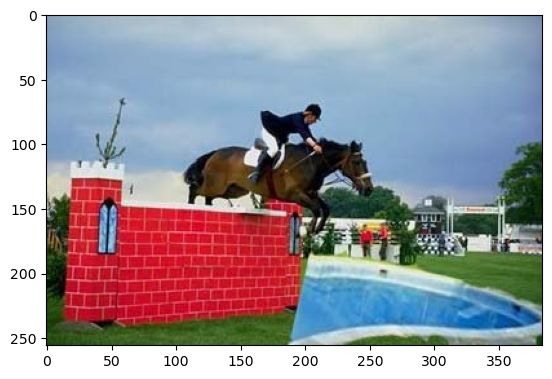

torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])


In [9]:
# read and visualize an image
img = cv.imread(f"/home/csgrad/akumar58/EVAL4/test_images/3.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

In [10]:
# pass the image through all the layers
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

In [11]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig(f"/home/csgrad/akumar58/EVAL4/cnn_manip/rgb_features/layer_{num_layer}.png")
    # plt.show()
    plt.close()

torch.Size([64, 64, 64])
Saving layer 0 feature maps...
torch.Size([64, 64, 64])
Saving layer 1 feature maps...
torch.Size([64, 64, 64])
Saving layer 2 feature maps...
torch.Size([64, 64, 64])
Saving layer 3 feature maps...
torch.Size([64, 64, 64])
Saving layer 4 feature maps...
torch.Size([128, 32, 32])
Saving layer 5 feature maps...
torch.Size([128, 32, 32])
Saving layer 6 feature maps...
torch.Size([128, 32, 32])
Saving layer 7 feature maps...
torch.Size([128, 32, 32])
Saving layer 8 feature maps...
torch.Size([256, 16, 16])
Saving layer 9 feature maps...
torch.Size([256, 16, 16])
Saving layer 10 feature maps...
torch.Size([256, 16, 16])
Saving layer 11 feature maps...
torch.Size([256, 16, 16])
Saving layer 12 feature maps...
torch.Size([512, 8, 8])
Saving layer 13 feature maps...
torch.Size([512, 8, 8])
Saving layer 14 feature maps...
torch.Size([512, 8, 8])
Saving layer 15 feature maps...
torch.Size([512, 8, 8])
Saving layer 16 feature maps...
